<a href="https://colab.research.google.com/github/HSabbar/Detection-Fraude/blob/master/Detection_de_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de fraude avec Keras - Colab Notebooks



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams

In [0]:
%matplotlib inline

LABELS = ["Normal", "Fraude"]
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42


In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Dataset 
[*Obtenu sur Kaggle*](https://www.kaggle.com/mlg-ulb/creditcardfraud)

L'ensemble des données contiennent des transactions effectuées par carte de crédit en septembre 2013 par des titulaires de carte européens. Cet ensemble de données présente les transactions qui ont eu lieu en deux jours, où nous avons 492 fraudes sur 284 807 transactions. Le jeu de donnée est très déséquilibré, la classe positive (fraudes) représente 0,172% de toutes les transactions.

Il ne contient que des variables d'entrée numériques qui sont le résultat d'une transformation PCA. Malheureusement, en raison de problèmes de confidentialité, nous ne pouvons pas fournir les fonctionnalités d'origine et plus d'informations sur les données. Les fonctionnalités V1, V2,… V28 sont les principaux composants obtenus avec PCA, les seules fonctionnalités qui n'ont pas été transformées avec PCA sont 'Time' et 'Amount'. La fonction «Time» contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données.

In [83]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/dataset/creditcard.csv")
df_tmp = df
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
import matplotlib.pyplot as plt



1.    Le jeu de donnée est très déséquilibré, la classe positive (fraudes) représente 0,172% de toutes les transactions.
2.   La classe de normal (non Fraude) représente 99,83%



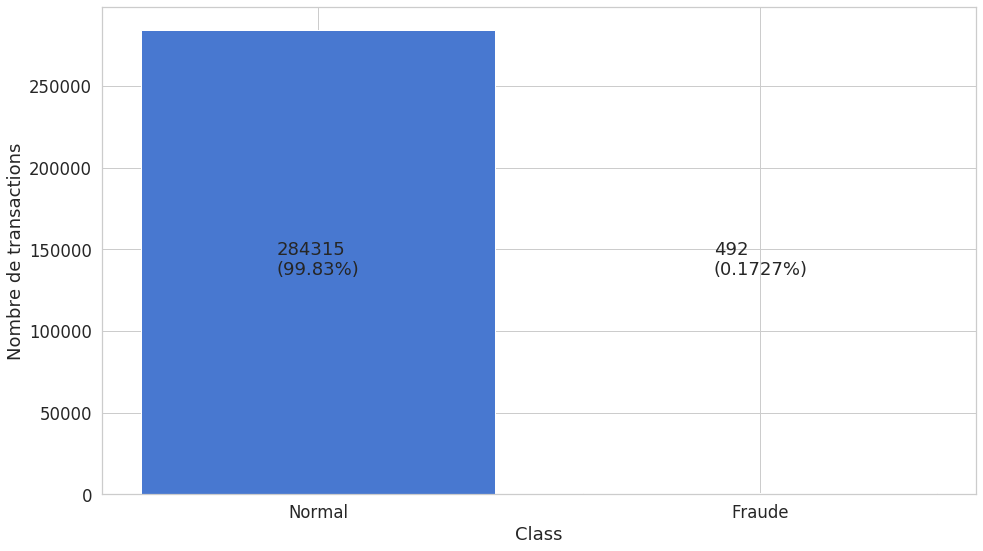

In [48]:
plt.bar(LABELS, df['Class'].value_counts(), color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Nombre de transactions')
plt.annotate('{}\n({:.4}%)'.format(df['Class'].value_counts()[0], df['Class'].value_counts()[0]/df['Class'].count()*100),
             (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}\n({:.4}%)'.format(df['Class'].value_counts()[1], df['Class'].value_counts()[1]/df['Class'].count()*100),
             (0.70, 0.45), xycoords='axes fraction')
plt.tight_layout()

#Normaliser et mettre à l'échelle les données : 
Le temps et la montant ont une importance très différentes, ce qui entraînera probablement un déséquilibre des données. Il est donc courant de redimensionner les données à des importance similaires. 

La plupart des données (autres que le «temps» et la montant) résultent du produit d'une analyse PCA. L'PCA effectuée sur l'ensemble de données l'a transformé en une forme standard-normale. Je ferai de même pour les colonnes «temps» et «montant» 

In [0]:
# pre- processing
from sklearn.preprocessing import StandardScaler
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))


In [50]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


*Extraire des données de validation de modele que nous ne passons pas à l'apprentissage* 

In [51]:
Fraude = df[df.Class == 1]
normal = df[df.Class == 0]
print(Fraude.shape)

X_val_model_fraude =  df.iloc[[541, 623,4920, 6108]] 
X_val_model_normal =  df.iloc[[0, 2,3, 4]] 
print(len(df))

(492, 31)
284807


In [0]:
df = df.drop(df.index[[541, 623,4920, 6108]])
df = df.drop(df.index[[0, 2,3, 4]])

In [53]:
X_val_model_fraude = X_val_model_fraude.iloc[:, df.columns != 'Class']
X_val_model_normal = X_val_model_normal.iloc[:, df.columns != 'Class']

X_val_model_fraude = np.array(X_val_model_fraude)
X_val_model_normal = np.array(X_val_model_normal)


frauds = df[df.Class == 1]
print(frauds.shape)
print(len(df))

(488, 31)
284799


In [54]:
284807 - 284799

8

In [55]:
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
5,-1.996541,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.338556
6,-1.996499,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.333279
7,-1.996436,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.190107
8,-1.996436,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.019392


In [56]:
y.head()

,Class
1,0
5,0
6,0
7,0
8,0


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [59]:
print(X_train.shape)
print(X_train.shape)

(199359, 30)
(199359, 30)


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_trian = np.array(y_train)
y_test = np.array(y_test)

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import Dropout

In [62]:
model =  Sequential([
    Dense(units=16, input_dim = 30,activation = 'relu'),
    Dense(units = 24, activation = 'relu'),
    Dropout(0.5),
    Dense( 20, activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_12 (Dense)             (None, 24)                408       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                500       
_________________________________________________________________
dense_14 (Dense)             (None, 24)                504       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 25        
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
____________________________________________________

In [63]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_trian, batch_size =15, epochs = 5)

Epoch 1/5
199359/199359 [==============================] - 69s 344us/step - loss: 0.0082 - acc: 0.9990
Epoch 2/5
199359/199359 [==============================] - 68s 343us/step - loss: 0.0044 - acc: 0.9993
Epoch 3/5
199359/199359 [==============================] - 68s 343us/step - loss: 0.0039 - acc: 0.9994
Epoch 4/5
199359/199359 [==============================] - 68s 343us/step - loss: 0.0036 - acc: 0.9994
Epoch 5/5
199359/199359 [==============================] - 68s 340us/step - loss: 0.0036 - acc: 0.9994


*Evaluer le modèle formé, Sa sortie est la précision et la perte*

In [64]:
score = model.evaluate(X_test, y_test)
print(score)

85440/85440 [==============================] - 5s 53us/step
[0.0043453938963726796, 0.9994147940074907]


**La prédiction :**

In [0]:
def prediction(modell, y, str):
  ynew = modell.predict(y)
  for i in range(len(y)) :
    if str == "fraude": 
      if ynew[i].round() != 0:
        print("X ; prediction = %s " % ( ynew[i].round()))
      else:
        print("X ; prediction = %s (error) =  %s " % ( ynew[i].round(), ynew[i]))
    else : 
      print("X ; prediction = %s " % ( ynew[i].round()))


**Validation de model sur la data fraude**


*   0 : noraml 
*   1 : fraude 



In [66]:
prediction(model, X_val_model_fraude, str="fraude")

X ; prediction = [1.] 
X ; prediction = [0.] (error) =  [5.13494e-05] 
X ; prediction = [1.] 
X ; prediction = [1.] 


In [67]:
prediction(model, X_val_model_fraude, str="fraude")

X ; prediction = [1.] 
X ; prediction = [0.] (error) =  [5.13494e-05] 
X ; prediction = [1.] 
X ; prediction = [1.] 


**Validation de model sur la data noraml**

In [68]:
prediction(model, X_val_model_normal, str="normal")

X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 


In [69]:
prediction(model, X_val_model_normal, str="normal")

X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 


**On remarque que la détection de fraude de ce model est de 4/5 assze fiable**

*sachant que le model n'a jamais vu ses données*



In [0]:
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/model.h5")

In [71]:
!ls "/content/gdrive/My Drive/Colab Notebooks"

 CCF.ipynb  'Detection de Fraude.ipynb'   model_autoencoder__.h5
 dataset     detection_fraude.ipynb	  model.h5


In [78]:
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/model.h5")
 
# Évaluer le modèle, chargé sur les données de test ...
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


acc: 99.94%


## **Autoencoders**

Les encodeurs automatiques peuvent sembler assez bizarres au premier abord. Le travail de ces modèles est de prédire l'entrée, étant donné cette même entrée. Déroutant? C'était définitivement pour moi, la première fois que je l'ai entendu.

Plus précisément, examinons les réseaux de neurones à encodeur automatique. Cet encodeur automatique essaie d'apprendre à approximer la fonction d'identité suivante:

$$\textstyle f_{W,b}(x) \approx x$$
Tout en essayant de faire cela peut sembler trivial au début, il est important de noter que nous voulons apprendre une représentation compressée des données, donc trouver la structure. Cela peut être fait en limitant le nombre d'unités cachées dans le modèle. Ce type d'auto-encodeurs est considéré comme incomplet.

Voici une représentation visuelle de ce qu'un encodeur automatique pourrait apprendre:


**Erreur de reconstruction**

Nous optimisons les paramètres de notre modèle Autoencoder de telle sorte qu'un type spécial d'erreur - erreur de reconstruction est minimisé. En pratique, l'erreur quadratique traditionnelle est souvent utilisée:

$$\textstyle L(x,x') = ||\, x - x'||^2$$


In [84]:
df2 = df_tmp
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [85]:
df2["Time"] = df2["Time"].apply(lambda x : x / 3600 % 24)
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [86]:
#Scaling time et amount ...
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df2['scaled_amount'] = rob_scaler.fit_transform(df2['Amount'].values.reshape(-1,1))
df2['scaled_time'] = rob_scaler.fit_transform(df2['Time'].values.reshape(-1,1))

df2.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df2['scaled_amount']
scaled_time = df2['scaled_time']

df2.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df2.insert(0, 'scaled_amount', scaled_amount)
df2.insert(1, 'scaled_time', scaled_time)

print(len(df2))
df2.head()

284807


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.719153,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-1.719153,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.719121,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-1.719121,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.719090,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [88]:
#Prendre uniquement les cas non frauduleux...

non_fraud = df2[df2.Class == 0].sample(1000)
fraud = df2[df2.Class == 1]

print("Shape de non-fraude dataset est {}".format(non_fraud.shape))
print("Shape de fraude dataset est {}".format(fraud.shape))

Shape de non-fraude dataset est (1000, 31)
Shape de fraude dataset est (492, 31)


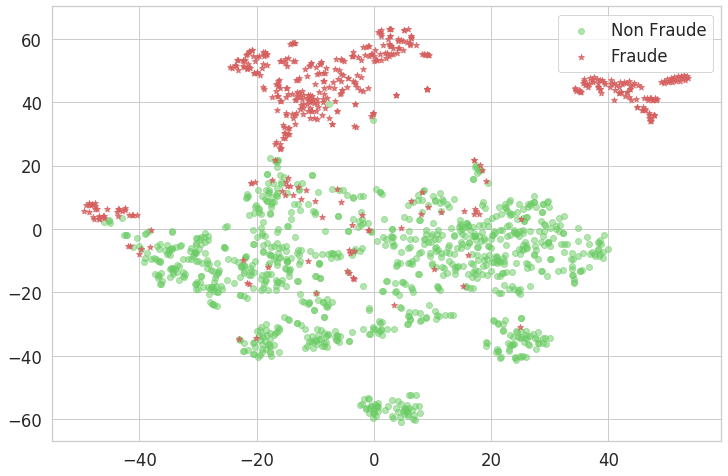

In [89]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2,perplexity = 30, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.5, label='Non Fraude')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='*', color='r', linewidth='1', alpha=0.8, label='Fraude')

    plt.legend(loc='best')
    plt.show()
    
df_tsne = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)    
X = df_tsne.drop(['Class'], axis = 1).values
Y = df_tsne["Class"].values
    
tsne_plot(X, Y)

In [0]:
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf

In [0]:
# input layer
input_layer = tf.keras.layers.Input(shape=(X.shape[1],))

# encoding 
encoded = tf.keras.layers.Dense(100, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoded = tf.keras.layers.Dense(50, activation='relu')(encoded)

# decoding 
decoded = tf.keras.layers.Dense(50, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(100, activation='tanh')(decoded)

# output layer
output_layer = tf.keras.layers.Dense(X.shape[1], activation='relu')(decoded)

In [93]:
autoencoder = tf.keras.Model(input_layer,output_layer)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_______________________________________________________

In [0]:
x = df2.drop(["Class"], axis=1)
y = df2["Class"].values

x_norm, x_fraud = x[y == 0], x[y == 1]

In [95]:
history = autoencoder.fit(x, x, 
                batch_size = 512, epochs = 30, 
                shuffle = True, validation_split = 0.20).history

Train on 227845 samples, validate on 56962 samples
Epoch 1/30
227845/227845 [==============================] - 2s 10us/sample - loss: 0.8187 - acc: 0.7758 - val_loss: 0.7181 - val_acc: 0.8737
Epoch 2/30
227845/227845 [==============================] - 2s 9us/sample - loss: 0.6756 - acc: 0.8911 - val_loss: 0.6723 - val_acc: 0.9071
Epoch 3/30
227845/227845 [==============================] - 2s 9us/sample - loss: 0.6477 - acc: 0.9148 - val_loss: 0.6574 - val_acc: 0.9195
Epoch 4/30
227845/227845 [==============================] - 2s 9us/sample - loss: 0.6345 - acc: 0.9303 - val_loss: 0.6594 - val_acc: 0.8982
Epoch 5/30
227845/227845 [==============================] - 2s 10us/sample - loss: 0.6321 - acc: 0.9283 - val_loss: 0.6368 - val_acc: 0.9217
Epoch 6/30
227845/227845 [==============================] - 2s 10us/sample - loss: 0.6225 - acc: 0.9409 - val_loss: 0.6267 - val_acc: 0.9491
Epoch 7/30
227845/227845 [==============================] - 2s 10us/sample - loss: 0.6215 - acc: 0.9361 - 

In [0]:
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/model_autoencoder__.h5")

In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.legend()
    plt.show()

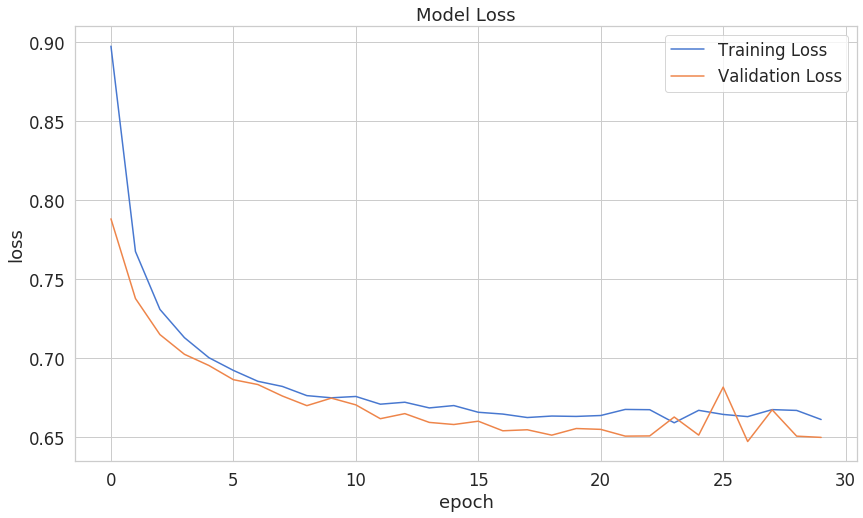

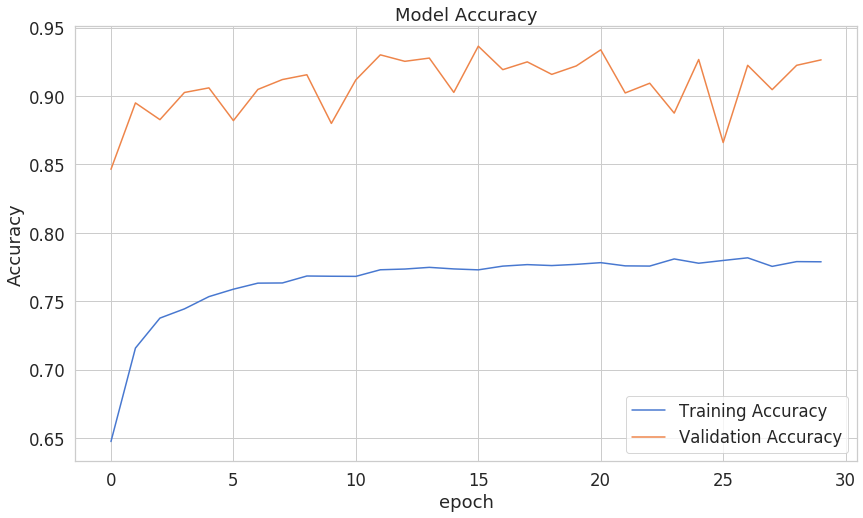

In [45]:
plot_metrics(history)

In [0]:
hidden_representation = tf.keras.models.Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [0]:
##la prédiction
norm_hid_rep = hidden_representation.predict(x_norm[:4000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

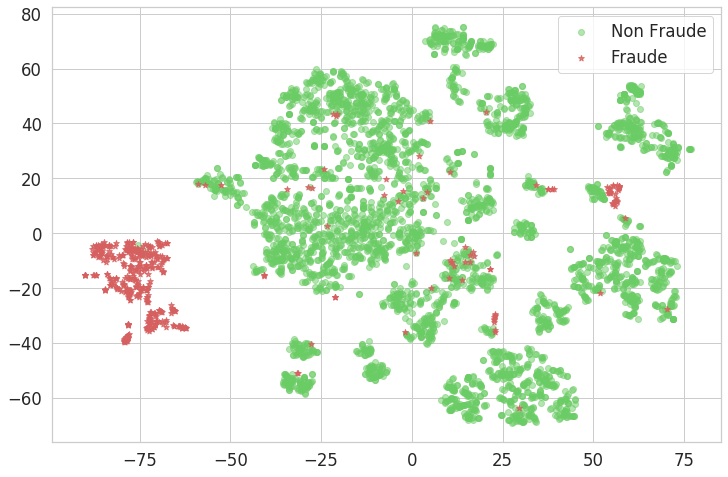

In [0]:
##Visualisation

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y)